In [4]:
#Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import TrainingArguments, Trainer
import warnings
warnings.filterwarnings('ignore')

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Loading the dataset (if working on Google Colab)
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
#df_train.head()

Mounted at /content/drive


In [10]:
# working on local machine
# os.chdir('/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/data')
# print(os.getcwd())

# df_train = pd.read_csv('train.csv')
# df_test = pd.read_csv('test.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Exploratory Data Analysis

In [11]:
# Summary of the target variable distribution
target_distribution = df_train['target'].value_counts(normalize=True)

# Summary of missing values in the training data
missing_values_train = df_train.isnull().sum()

# Summary of missing values in the test data
missing_values_test = df_test.isnull().sum()

print("Target Distribution:\n")
print(target_distribution)
print()
print("Missing Values in Training set:\n")
print(missing_values_train)
print()
print("Missing Values in Testing set:\n")
print(missing_values_test)

Target Distribution:

0    0.57034
1    0.42966
Name: target, dtype: float64

Missing Values in Training set:

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Testing set:

id             0
keyword       26
location    1105
text           0
dtype: int64


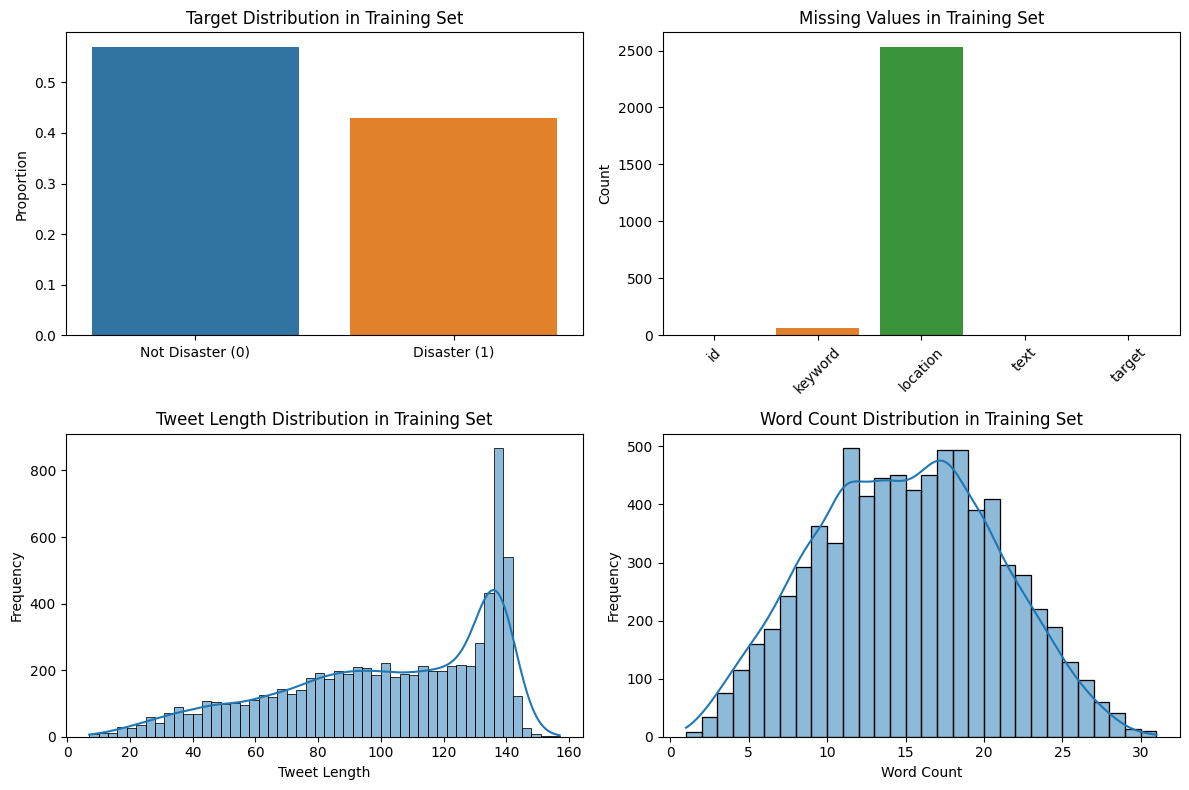

In [12]:
# Distribution of tweet lengths
tweet_length_train = df_train['text'].str.len()
tweet_length_test = df_test['text'].str.len()

# Distribution of number of words in tweets
word_count_train = df_train['text'].apply(lambda x: len(x.split()))
word_count_test = df_test['text'].apply(lambda x: len(x.split()))

# Create a figure to visualize EDA results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Target distribution
sns.barplot(ax=axes[0, 0], x=target_distribution.index, y=target_distribution.values)
axes[0, 0].set_title('Target Distribution in Training Set')
axes[0, 0].set_ylabel('Proportion')
axes[0, 0].set_xticklabels(['Not Disaster (0)', 'Disaster (1)'])

# Missing values in training set
sns.barplot(ax=axes[0, 1], x=missing_values_train.index, y=missing_values_train.values)
axes[0, 1].set_title('Missing Values in Training Set')
axes[0, 1].set_ylabel('Count')
for item in axes[0, 1].get_xticklabels():
    item.set_rotation(45)

# Tweet length distribution
sns.histplot(tweet_length_train, bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Tweet Length Distribution in Training Set')
axes[1, 0].set_xlabel('Tweet Length')
axes[1, 0].set_ylabel('Frequency')

# Word count distribution
sns.histplot(word_count_train, bins=30, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Word Count Distribution in Training Set')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# Filling missing values for 'keyword' and 'location' with the string 'unknown'
df_train['keyword'].fillna('unknown', inplace=True)
df_train['location'].fillna('unknown', inplace=True)
df_test['keyword'].fillna('unknown', inplace=True)
df_test['location'].fillna('unknown', inplace=True)

# Stopwords list
stop_words = set(stopwords.words('english'))

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK's part-of-speech tags to the format expected by the lemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
# Define the emoji pattern
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# Function to clean the text data
def clean_text(text):

    # Expand contractions
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"There's", "There is", text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower().strip()

    # Remove Emoji
    text = emoji_pattern.sub(r'', text)

    # Tokenization and stopwords removal
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Part-of-speech tagging
    pos_tagged = nltk.pos_tag(filtered_tokens)

    # Lemmatization
    lemmatized_text = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tagged]

    return ' '.join(lemmatized_text)

# Cleaning the text column in the dataset
df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

In [15]:
# Performing TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df_train['text_clean'])
X_tfidf = X_tfidf.toarray()

In [16]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, df_train['target'], test_size=0.2, random_state=42)

# Display the shapes of the output vectors
X_train.shape, X_val.shape

((6090, 5000), (1523, 5000))

# Model from stratch

In [17]:
import StratchModels

## Naive Bayes' Classifier

In [18]:
# Training the model
nb = StratchModels.MultinomialNaiveBayes()
nb.fit(X_train, y_train)

In [19]:
# Predicting on the validation set
y_pred = nb.predict(X_val)  # Convert sparse matrix to dense

In [20]:
# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8017071569271176
Precision: 0.8382066276803118
Recall: 0.662557781201849
F1 Score: 0.7401032702237522


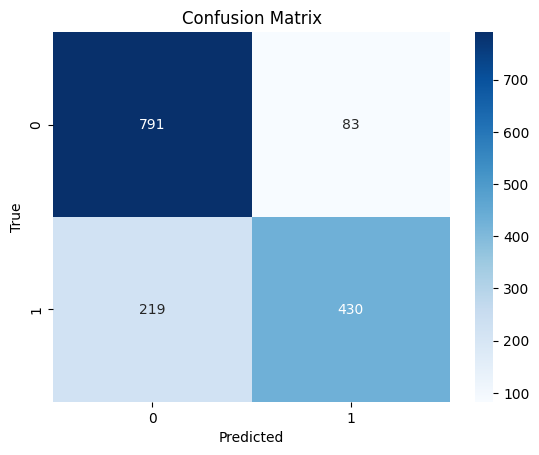

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression

In [22]:
lr_model = StratchModels.LogisticRegression()
lr_model.fit(X_train, y_train)

lr_ypred_train = lr_model.predict(X_train)
print('Training Accuracy: ', accuracy_score(y_train, lr_ypred_train))

Training Accuracy:  0.9827586206896551


In [23]:
lr_ypred_val = lr_model.predict(X_val)

print('Testing Accuracy: ', accuracy_score(y_val, lr_ypred_val))
print('F1-Score: ',f1_score(y_val,lr_ypred_val))

Testing Accuracy:  0.7150361129349967
F1-Score:  0.6761194029850746


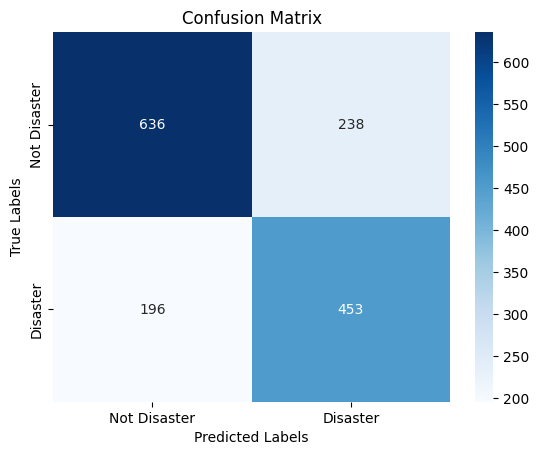

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, lr_ypred_val)
# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Random Forest

In [25]:
# Create and train a Random Forest
rf_model = StratchModels.RandomForestClassifier(n_trees=100, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

In [26]:
rf_ypred_train = rf_model.predict(X_train)
print('Training Accuracy: ', accuracy_score(y_train, rf_ypred_train))

Training Accuracy:  0.6187192118226601


In [27]:
rf_ypred_val = rf_model.predict(X_val)

In [28]:
# Evaluation Metrics
accuracy = accuracy_score(rf_ypred_val, y_val)
precision = precision_score(rf_ypred_val, y_val)
recall = recall_score(rf_ypred_val, y_val)
f1 = f1_score(rf_ypred_val, y_val)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6217990807616546
Precision: 0.14175654853620956
Recall: 0.8288288288288288
F1 Score: 0.24210526315789474


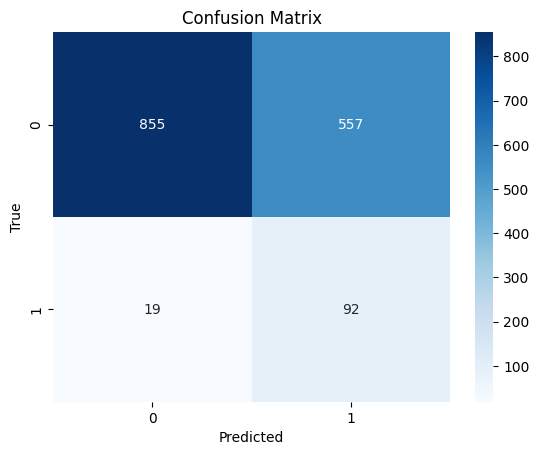

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(rf_ypred_val, y_val)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# LSTM

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input ,LSTM, Dropout,Flatten,Bidirectional, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping

In [ ]:
df_train = df_train[['text', 'target']]
df_train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_train['text'], df_train['target'], test_size= 0.2, random_state= 42)

In [ ]:
from LSTM_Model.Glove_embeddings import GloveEmbedder

# Download below model from stanford - https://nlp.stanford.edu/projects/glove/
glove_file_path = '/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/LSTM_Model/glove.twitter.27B.100d.txt'

glove_embedder = GloveEmbedder(glove_file_path)

glove_embeddings_array = glove_embedder.generate_embeddings_array(x_test)
glove_embeddings_array.shape

(1523, 31, 100)

In [ ]:
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred, precision, recall):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)

    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
    return f1

@tf.function
def compiled_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, precision_metric, recall_metric)

model_path =  '/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/LSTM_Model/LSTM_model_Glove100.h5'
Lstm_model = tf.keras.models.load_model(model_path,custom_objects={'compiled_f1_score': compiled_f1_score})

2023-12-07 13:15:36.727553: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-07 13:15:36.727609: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-07 13:15:36.727616: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-07 13:15:36.727824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 13:15:36.728165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
Lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 31, 256)           234496    
 ional)                                                          
                                                                 
 batch_normalization_12 (Ba  (None, 31, 256)           1024      
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 31, 256)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 31, 512)           1050624   
 ional)                                                          
                                                                 
 batch_normalization_13 (Ba  (None, 31, 512)           2048      
 tchNormalization)                                    

In [ ]:
y_pred = Lstm_model.predict(glove_embeddings_array)
y_pred = (y_pred > 0.5).astype(int)

2023-12-07 13:15:59.719718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 3s 44ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       874
           1       0.75      0.76      0.76       649

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



<Axes: >

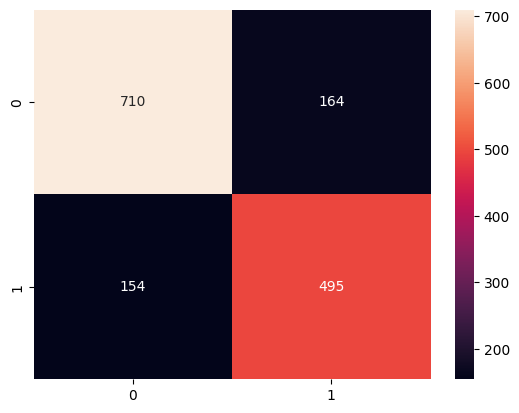

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='d' )

## BERT - Bidirectional Encoder Representations from Transformers

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

# Calculate the average word count
average_word_count = df_train['word_count'].mean()

print(f"The average word count per tweet is: {average_word_count}")

The average word count per tweet is: 14.903585971364771


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization and encoding of the dataset
def preprocess_data(data, tokenizer, max_length=128):
    return tokenizer(
        text=data['text_clean'].tolist(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Splitting the data
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

# Apply preprocessing to the split data
encoded_train = preprocess_data(train_df, tokenizer)
encoded_val = preprocess_data(val_df, tokenizer)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create datasets for the new training and validation sets
train_labels = train_df['target'].tolist()
val_labels = val_df['target'].tolist()

train_dataset = TweetDataset(encoded_train, train_labels)
val_dataset = TweetDataset(encoded_val, val_labels)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs'
)

# Update the Trainer with the new training dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Step,Training Loss
500,0.493900
1000,0.340000


TrainOutput(global_step=1143, training_loss=0.3954185192144866, metrics={'train_runtime': 418.1719, 'train_samples_per_second': 43.69, 'train_steps_per_second': 2.733, 'total_flos': 1201759745356800.0, 'train_loss': 0.3954185192144866, 'epoch': 3.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()

In [ ]:
predictions = trainer.predict(val_dataset)
# Process the predictions to evaluate the model

In [ ]:
# Extract logits from the predictions
logits = predictions.predictions

# Apply a softmax to convert logits to probabilities
probabilities = torch.nn.functional.softmax(torch.from_numpy(logits), dim=-1)

# Convert probabilities to actual predictions (0 or 1)
predicted_labels = torch.argmax(probabilities, axis=1).numpy()

In [ ]:
# Calculate metrics
accuracy = accuracy_score(val_labels, predicted_labels)
precision = precision_score(val_labels, predicted_labels)
recall = recall_score(val_labels, predicted_labels)
f1 = f1_score(val_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8063033486539725
Precision: 0.7626112759643917
Recall: 0.7919876733436055
F1 Score: 0.7770219198790627


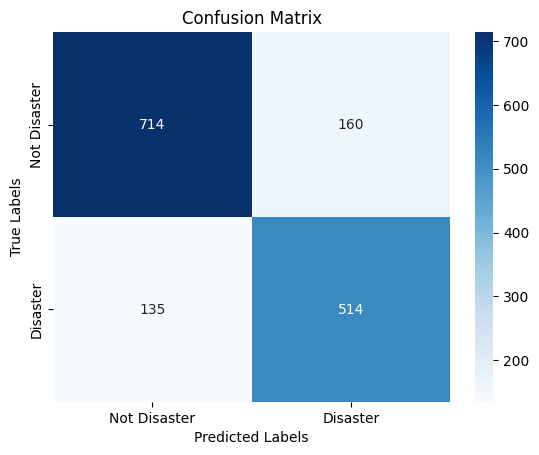

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBOOST CLASSIFIER

In [30]:
pip install xgboost

In [31]:
import xgboost as xgb
# Create DMatrix objects for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',  # for multi-class classification
    'num_class': 3,  # number of classes in the target variable
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'mlogloss'
}

# Train the XGBoost model
num_round = 100
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
xg_y_pred = bst.predict(dtrain)

# Evaluate the accuracy
accuracy = accuracy_score(y_train, xg_y_pred)
print(f'Accuracy On Train Test: {accuracy}')


Accuracy On Train Test: 0.7584564860426929


In [32]:
dVal = xgb.DMatrix(X_val, label=y_val)
xg_ypred_val = rf_model.predict(X_val)

In [33]:
# Evaluation Metrics
accuracy = accuracy_score(xg_ypred_val, y_val)
precision = precision_score(xg_ypred_val, y_val)
recall = recall_score(xg_ypred_val, y_val)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6217990807616546
Precision: 0.14175654853620956
Recall: 0.8288288288288288
F1 Score: 0.24210526315789474


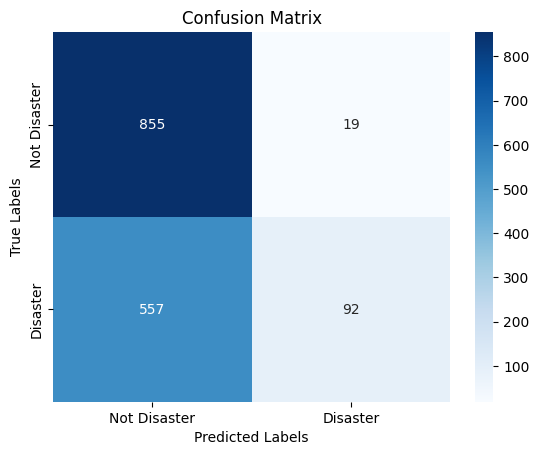

In [34]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, xg_ypred_val)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()